In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp = '1_icews14'
experiments = ['2_yago', '3_wikiold', '4_smallpedia', '1_icews14', '5_icews18' ]
dataset_names = {'1_icews14': 'ICEWS14', '2_yago': 'YAGO', '3_wikiold': 'WIKI', '4_smallpedia': 'smallpedia',
                 '5_icews18': 'ICEWS18', '6_gdelt': 'GDELT'}

In [3]:
import pandas as pd

# Example: combine summaries for multiple datasets
summaries = []

for exp in experiments:
    # same parsing logic as before
    data = []
    score_data = {}
    file_path = f"./../explanations/{exp}/output/ruletypes.txt"
    dataset_name = exp
    with open(file_path) as f:
        for line in f:
            rule, score = line.strip().split(",")
            data.append((rule.strip(), float(score.strip())))
            if rule in score_data:
                score_data[rule] += float(score.strip())
            else:
                score_data[rule] = float(score.strip())
    df = pd.DataFrame(data, columns=["rule_type", "score"])
    summary = df["rule_type"].value_counts(normalize=True) * 100
    summary = summary.reset_index()
    summary.columns = ["rule_type", "percent_of_total"]
    summary["dataset"] = dataset_names[dataset_name]
    summaries.append(summary)

# Combine all
combined = pd.concat(summaries, ignore_index=True)


In [4]:
import pandas as pd
from collections import defaultdict

summaries = []

for exp in experiments:
    file_path = f"./../explanations/{exp}/output/ruletypes.txt"
    dataset_name = dataset_names[exp]  # use your friendly dataset name mapping

    # collect rule + score pairs
    data = []
    with open(file_path) as f:
        for line in f:
            rule, score = line.strip().split(",")
            data.append((rule.strip(), float(score.strip())))

    # make dataframe for this dataset
    df = pd.DataFrame(data, columns=["rule_type", "score"])

    # --- summary for percent of total ---
    summary = df["rule_type"].value_counts(normalize=True) * 100
    summary = summary.reset_index()
    summary.columns = ["rule_type", "percent_of_total"]

    # --- collect score distributions per rule type ---
    score_distributions = df.groupby("rule_type")["score"].apply(list).reset_index()
    score_distributions.columns = ["rule_type", "score_distribution"]

    # --- merge summaries ---
    merged = pd.merge(summary, score_distributions, on="rule_type", how="left")
    merged["dataset"] = dataset_name

    summaries.append(merged)

# Combine all datasets
combined = pd.concat(summaries, ignore_index=True)


In [5]:
# Create figure
# Increase all font sizes by +2
import matplotlib as mpl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
def bump(val, inc=2):
    """Increase font size even if val is 'medium', 'large', etc."""
    return mpl.font_manager.FontProperties(size=val).get_size_in_points() + inc

plt.rcParams.update({
    "font.size": bump(plt.rcParams["font.size"]),
    "axes.titlesize": bump(plt.rcParams["axes.titlesize"]),
    "axes.labelsize": bump(plt.rcParams["axes.labelsize"], inc=1),
    "xtick.labelsize": bump(plt.rcParams["xtick.labelsize"]),
    "ytick.labelsize": bump(plt.rcParams["ytick.labelsize"], inc=1),
    # "legend.fontsize": bump(plt.rcParams["legend.fontsize"]),
})

C:\Users\jgasting\AppData\Local\Temp\ipykernel_31032\274559994.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis", num_colors)


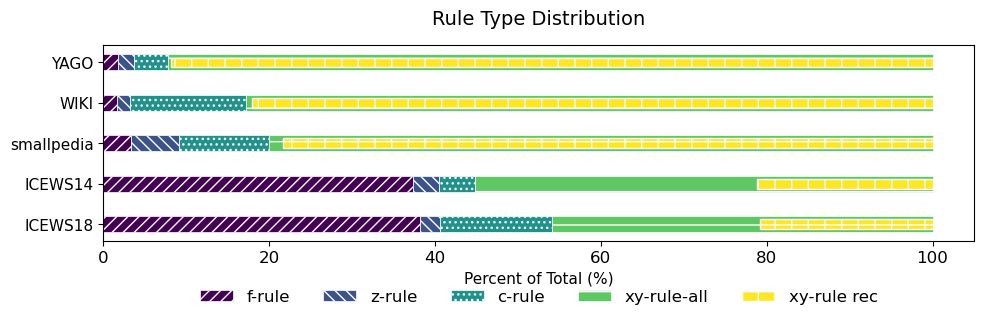

In [6]:


# Pivot the data
index_order = [dataset_names[e] for e in experiments if dataset_names.get(e) in combined['dataset'].unique()]
pivoted = combined.pivot(index="dataset", columns="rule_type", values="percent_of_total")
pivoted = pivoted.reindex(index_order).fillna(0)
bar_width = 0.4

# Combine rule variants
pivoted["xy-rule-all"] = pivoted["xy-rule"] + pivoted["xy-rule_rec"]
pivoted["c-rule"] = pivoted["c-rule"] + pivoted["c-rule_backward"]

# Keep custom order
rule_order = ["f-rule", "z-rule", "c-rule", "xy-rule-all"]
pivoted_new = pivoted[["f-rule", "z-rule", "c-rule", "xy-rule-all"]]

# Define a colorblind-friendly palette (from Okabe–Ito)
# Use Viridis colormap
num_colors = len(pivoted_new.columns)+1
viridis = cm.get_cmap("viridis", num_colors)
colors = [viridis(i) for i in range(num_colors)]
hatches = ["///", "\\\\\\", "...",  "-",  "+", ]  # patterns (no hatch for last group)



fig,ax = plt.subplots(figsize=(10, 3.5))

# Plot stacked horizontal bars
left = np.zeros(len(pivoted_new))
for i, (col, color, hatch) in enumerate(zip(pivoted_new.columns, colors, hatches)):
    bars = ax.barh(
        pivoted_new.index,
        pivoted_new[col],
        left=left,
        color=color,
        edgecolor="white",
        hatch=hatch,
        height=bar_width,
        label=col,
        linewidth=0.5,
    )
    left += pivoted_new[col].values

# Overlay the xy-rule_rec fraction (narrower)
left_xy_rec = (
    pivoted_new[["c-rule", "f-rule", "z-rule"]].sum(axis=1)
    + pivoted["xy-rule"]
)
ax.barh(
    pivoted.index,
    pivoted["xy-rule_rec"],
    left=left_xy_rec,
    color=viridis(num_colors-1),  # darker blue
    hatch=hatches[-1],
    edgecolor="white",
    height=bar_width * 0.6,
    label="xy-rule rec",
)

# Styling
ax.set_title("Rule Type Distribution", pad=15)
ax.set_xlabel("Percent of Total (%)")
# ax.set_ylabel("Dataset")
ax.invert_yaxis()  # so first dataset is at top
ax.legend(
    loc="upper center",               # center it horizontally
    bbox_to_anchor=(0.5, -0.17),      # move below the plot (adjust -0.15 as needed)
    ncol=len(rule_order)+1,             # spread legend items in one horizontal row
    frameon=False                     # optional: cleaner look
)
plt.tight_layout()



plt.savefig("./rule_type_distribution_grouped.png", dpi=300)
plt.savefig("./rule_type_distribution_grouped.pdf")

plt.show()

In [7]:
import pandas as pd
from collections import defaultdict

summaries = []

for exp in experiments:
    file_path = f"./../explanations/{exp}/output/ruletypes.txt"
    dataset_name = dataset_names[exp]  # use your friendly dataset name mapping

    # collect rule + score pairs
    data = []
    with open(file_path) as f:
        for line in f:
            rule, score = line.strip().split(",")
            rule = rule.split('_')[0]
            data.append((rule.strip(), float(score.strip())))

    # make dataframe for this dataset
    df = pd.DataFrame(data, columns=["rule_type", "score"])

    # --- summary for percent of total ---
    summary = df["rule_type"].value_counts(normalize=True) * 100
    summary = summary.reset_index()
    summary.columns = ["rule_type", "percent_of_total"]

    # --- collect score distributions per rule type ---
    score_distributions = df.groupby("rule_type")["score"].apply(list).reset_index()
    score_distributions.columns = ["rule_type", "score_distribution"]

    # --- merge summaries ---
    merged = pd.merge(summary, score_distributions, on="rule_type", how="left")
    merged["dataset"] = dataset_name

    summaries.append(merged)

# Combine all datasets
combined_new = pd.concat(summaries, ignore_index=True)

C:\Users\jgasting\AppData\Local\Temp\ipykernel_31032\1408698246.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(rule_order)+1)
C:\Users\jgasting\AppData\Local\Temp\ipykernel_31032\1408698246.py:58: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  patch.set_hatch(hatch)
C:\Users\jgasting\AppData\Local\Temp\ipykernel_31032\1408698246.py:93: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], hatch=hatches[

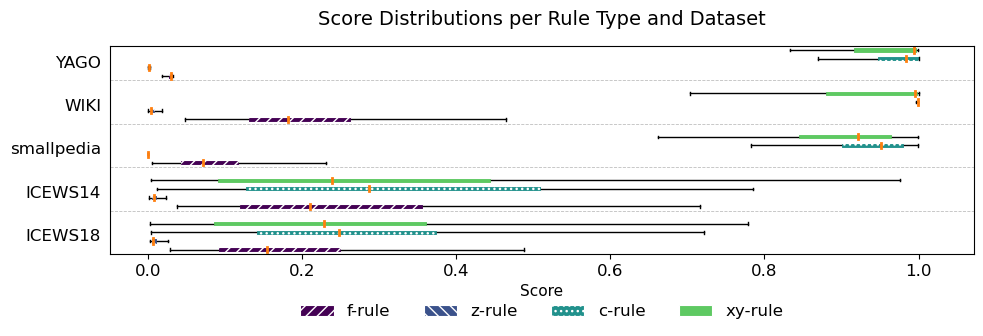

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# --- Setup ---
rule_order = ["f-rule", "z-rule", "c-rule", "xy-rule"]

combined_new = combined_new[combined_new["rule_type"].isin(rule_order)]

# Viridis color palette
cmap = cm.get_cmap("viridis", len(rule_order)+1)
colors = [cmap(i) for i in range(len(rule_order))]
hatches = ["///", "\\\\\\", "...", ' ', '+']  # patterns (no hatch for last group)


datasets = [dataset_names[e] for e in experiments[::-1] if dataset_names.get(e) in combined_new["dataset"].unique()]
n_rules = len(rule_order)
spacing = n_rules + 1  # controls vertical spacing between datasets

fig, ax = plt.subplots(figsize=(10, 3.5))
positions = []
labels = []
color_list = []
hatch_list = []
data = []

# Collect data and plotting positions
for i, dataset in enumerate(datasets):
    df_subset = combined_new[combined_new["dataset"] == dataset]
    for j, rule in enumerate(rule_order):
        vals = df_subset.loc[df_subset["rule_type"] == rule, "score_distribution"]
        if len(vals) > 0:
            data.append(vals.values[0])
        else:
            data.append([])
        positions.append(i * spacing + j)
        labels.append(f"{dataset}\n{rule}")
        color_list.append(colors[j])
        hatch_list.append(hatches[j])

# Create horizontal boxplots
bp = ax.boxplot(
    data,
    positions=positions,
    vert=False,
    patch_artist=True,
    widths=0.6,
    showfliers=False,
    medianprops=dict(color="#ff7f0e", linewidth=2, solid_capstyle="projecting"), 
)

# Apply colors + hatches
for patch, color, hatch in zip(bp["boxes"], color_list, hatch_list):
    patch.set_facecolor(color)
    patch.set_edgecolor("white")
    patch.set_linewidth(0.8)
    patch.set_hatch(hatch)

# --- Style axes ---
ax.set_xlabel("Score")
# ax.set_ylabel("Dataset / Rule Type")
ax.set_title("Score Distributions per Rule Type and Dataset", pad=15)

# Remove cluttered y-tick labels
ax.set_yticks([])

# Add grey separator lines between dataset blocks
for i in range(1, len(datasets)):
    y_sep = i * spacing - 0.5
    ax.axhline(y=y_sep, color="gray", linestyle="--", linewidth=0.6, alpha=0.5)

# Add dataset labels between blocks (normal weight)
x_min, x_max = ax.get_xlim()
x_text = x_min  - 0.01 * (x_max - x_min)  # add a little more space on the left
for i, dataset in enumerate(datasets):
    center = i * spacing + (n_rules - 1) / 2
    ax.text(
        x_text,
        center,
        dataset,
        ha="right",
        va="center",
        fontsize=12,
        fontweight="normal",  # not bold
    )

# Adjust x-limits to make room for labels
ax.set_xlim(x_min, x_max + 0.02 * (x_max - x_min))

# Legend
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], hatch=hatches[i], edgecolor="white")
    for i in range(len(rule_order))
]
ax.legend(
    loc="upper center",               # center it horizontally
    labels=rule_order,
    bbox_to_anchor=(0.5, -0.17),      # move below the plot (adjust -0.15 as needed)
    ncol=len(rule_order),             # spread legend items in one horizontal row
    frameon=False                     # optional: cleaner look
)
plt.tight_layout()


plt.tight_layout()

plt.savefig("./rule_type_distribution_boxplot.png", dpi=300)
plt.savefig("./rule_type_distribution_boxplot.pdf")

plt.show()
